## PyTorch 학습 레벨 2 - 006
---

### 연습처리
- [파이토치 기본 익히기](https://tutorials.pytorch.kr/beginner/basics/intro.html)와 torchvision에서 제공하는 [vgg 모델](https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py)을 재구성하여 작성

### VGG16 작성 및 학습

![](https://miro.medium.com/max/700/1*gU5m4XO2awEM6Zp4DkirFA.png)

#### 추가설명
- MaxPooling
    - `nn.MaxPool2d()`는 CNN에서 특징 맵의 크기를 줄이면서 중요한 정보를 보존하고, 계산 효율성을 높이며, 모델의 불변성을 증가시키고, 과적합을 방지하는 역할
- 사용이유
    1. 특징 추출을 위한 차원 축소
    2. 계산 효율성 증가
    3. 불변성 확보 (Translation Invariance)
    4. 과적합 방지

- VGG16 모델을 CIFAR-10 데이터를 학습 시켜볼 수 있는 이미지 분류기로 정의하고 이를 학습
- 작성해야하는 분류기와 학습 환경에 대한 조건
    - transforms : 정규화만 진행
    - 모델 구조 : 입력 이미지의 형상이 (3, 32, 32)이므로 아래의 구조를 따르도록 함
        - feature [32, 32, M, 64, 64, M, 128, 128, 128, M, 256, 256, 256, M, 512, 512, 512, M] + classifier [AA, 4096, 4096, 1000]
        - feature
            - n(숫자) : filter의 수가 n개인 2d Conv Layer, `kernel_size=3`, `padding=1`
            - M : Max Pooling Layer, `kernel_size=2`, `padding=2`
            - Conv Layer 이후의 activation func는 ReLU를 사용
        - classifier
            - AA : Adaptive Average Pooling(7x7)
            - n(숫자) : Linear(n unit)
    - loss 함수 : CrossEntropyLoss
    - optimizer = SGD, lr = 0.005, momentum=0.9
        - StepLR를 사용하여 5 step 마다 lr를 0.9배씩 줄이며 학습
    - 학습 과정에서 train set과 test set에 대한 loss와 accuracy를 출력하고, 학습 종료 후 matrix의 변화를 plot으로 출력
    - 학습이 완료된 모델을 `my_vgg16`이라는 이름으로 [저장](https://tutorials.pytorch.kr/beginner/basics/saveloadrun_tutorial.html)

In [1]:
# 설치
!pip install torchinfo

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# parameters
lr = 0.001
epochs = 15
batch_size = 128

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader = DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transform, download=True),
    batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transform),
    batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.7MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

##### 모델 정의

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        
vgg16 = VGG16(10).to(device)
summary(vgg16, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [64, 10]                  --
├─Sequential: 1-1                        [64, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 64, 32, 32]          36,928
│    └─ReLU: 2-4                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-5                    [64, 64, 16, 16]          --
│    └─Conv2d: 2-6                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-7                         [64, 128, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 128, 16, 16]         147,584
│    └─ReLU: 2-9                         [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-10                   [64, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [64, 256, 8, 8]           29

- loss function, optimizer, learing rate scheduler 정의

In [7]:
criterion = nn.CrossEntropyLoss().to(device) # loss func
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001) # optimizer
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) # learning rate scheduler

- 학습 함수 정의

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, total_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        X, y = X.to(device).float(), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # train loss, train acc 계산
        total_loss += loss.item()
        total_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return total_loss / num_batches, total_acc / size

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device).float(), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return test_loss / num_batches, correct / size

def fit(model, train_loader, validation_loader, loss_fun, optimizer):
    history = {key: [] for key in ['acc', 'val_acc', 'loss', 'val_loss']}
    for t in range(epochs):  
        print(f"Epoch {t+1}/{epochs}\n-------------------------------")
        _loss, _acc = train_loop(train_loader, model, loss_fun, optimizer)
        _val_loss, _val_acc = test_loop(val_loader, model, loss_fun)
        print(f"loss: {_loss:>.5f} - accuracy: {_acc:>.5f} - val_loss: {_val_loss:>.5f} - val_accuracy: {_val_acc:>.5f}\n")

        for key, value in zip(['acc', 'val_acc', 'loss', 'val_loss'], 
                              [_acc, _val_acc, _loss, _val_loss]):
            history[key].append(value)
    return history

In [9]:
import matplotlib.pyplot as plt

def show_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, key in zip(axes, ['acc', 'loss']):
        ax.plot(history[key], 'r', label='train')
        ax.plot(history['val_' + key], 'b', label='validation')
        ax.legend()
        ax.set_title(key)
    plt.show()

##### vgg16 학습

Epoch 1/15
-------------------------------
loss: 2.302730  [    0/50000]
loss: 2.302252  [12800/50000]
loss: 2.300332  [25600/50000]
loss: 2.301469  [38400/50000]
loss: 2.30597 - accuracy: 0.09954 - val_loss: 2.30274 - val_accuracy: 0.09990

Epoch 2/15
-------------------------------
loss: 2.303488  [    0/50000]
loss: 2.303260  [12800/50000]
loss: 2.304285  [25600/50000]
loss: 2.306375  [38400/50000]
loss: 2.30283 - accuracy: 0.09874 - val_loss: 2.30278 - val_accuracy: 0.09790

Epoch 3/15
-------------------------------
loss: 2.301963  [    0/50000]
loss: 2.301315  [12800/50000]
loss: 2.302601  [25600/50000]
loss: 2.304322  [38400/50000]
loss: 2.30281 - accuracy: 0.09790 - val_loss: 2.30273 - val_accuracy: 0.10020

Epoch 4/15
-------------------------------
loss: 2.303205  [    0/50000]
loss: 2.304300  [12800/50000]
loss: 2.302798  [25600/50000]
loss: 2.302315  [38400/50000]
loss: 2.30282 - accuracy: 0.09760 - val_loss: 2.30260 - val_accuracy: 0.10030

Epoch 5/15
---------------------

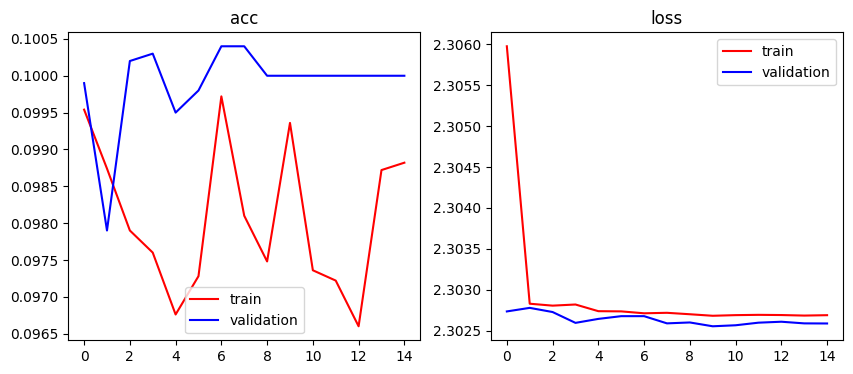

In [10]:
history = fit(vgg16, train_loader, val_loader, criterion, optimizer)
show_train_history(history)

##### 위의 훈련은 문제가 있음
- 정확도가 올라가지 않음. 다시 해볼 것
- 처음에 epochs를 2까지만 해서 제대로 되는지 먼저확인

##### 모델저장

In [11]:
torch.save(vgg16, './data/vgg16.pt') # 전체 모델 저장

##### 모델 로드

In [15]:
vgg16_loded = torch.load('./data/vgg16.pt', weights_only=False)
vgg16_loded

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

#### 뭐가 문제지????